# StressGait Analysis - Self-Reports

## Setup and Helper Functions

In [3]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import seaborn as sns
from biopsykit.questionnaires.utils import compute_scores, wide_to_long
from biopsykit.stats import StatsPipeline
from fau_colors import cmaps, register_fausans_font

from stressgait_analysis.dataset import StressGaitDataset

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [4]:
#register_fausans_font()
plt.close("all")
med_light = sns.color_palette(cmaps.med_light)
med_dark = sns.color_palette(cmaps.med_dark)
palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

controls_color = sns.color_palette(cmaps.wiso)[1]
omc_color = sns.color_palette(cmaps.med_dark)[1]

stressgait_palette = {
    "OMC": omc_color,
    "Control": controls_color
}
stressgait = [controls_color, omc_color]

In [5]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
base_path

PosixPath('/home/rzlin/ys64ofuj/Data/StressGait/Data')

In [6]:
export_path = Path("../../exports")
plot_path = export_path.joinpath("plots")
bp.utils.file_handling.mkdirs([export_path, plot_path])

export_path

PosixPath('../../exports')

In [7]:
dataset = StressGaitDataset(base_path, coarse_condition=True, exclude_missing_data=True)

dataset

,participant,condition
0,VP_01,OMC
1,VP_02,Control
2,VP_05,Control
3,VP_06,OMC
4,VP_07,Control
5,VP_08,Control
6,VP_11,Control
7,VP_12,Control
8,VP_13,OMC
9,VP_15,Control


In [8]:
order = ["Pre", "Marker", "Post"]
hue_order = ["Control", "OMC"]

In [22]:
data = dataset.questionnaire
data.head()
len(data.reset_index().participant.unique())

40

In [10]:
quest_dict = {
    "SSSQ-pre": data.filter(like="Pre_SSSQ").columns,
    "SSSQ-marker": data.filter(like="PreMocap_SSSQ").columns,
    "SSSQ-post": data.filter(like="Post_SSSQ").columns,
    "PANAS-pre": data.filter(like="Pre_PANAS").columns,
    "PANAS-marker": data.filter(like="PreMocap_PANAS").columns,
    "PANAS-post": data.filter(like="Post_PANAS").columns,
}

In [11]:
quest_data = compute_scores(
    data=data,
    quest_dict=quest_dict,
    quest_kwargs={"PANAS-pre": {"language": "german"}, "PANAS-post": {"language": "german"}},
)

quest_data.head()

,,SSSQ_Distress_pre,SSSQ_Worry_pre,SSSQ_Confidence_pre,SSSQ_NegativeAffect_pre,SSSQ_Motivation_pre,SSSQ_SelfEvaluation_pre,SSSQ_Total_pre,SSSQ_Distress_marker,SSSQ_Worry_marker,SSSQ_Confidence_marker,...,SSSQ_Total_post,PANAS_NegativeAffect_pre,PANAS_PositiveAffect_pre,PANAS_Total_pre,PANAS_NegativeAffect_marker,PANAS_PositiveAffect_marker,PANAS_Total_marker,PANAS_NegativeAffect_post,PANAS_PositiveAffect_post,PANAS_Total_post
participant,condition,,,,,,,,,,,,,,,,,,,,,
VP_01,OMC,1.4,2.75,2.8,1.666667,3.666667,3.000000,2.416667,1.0,2.0,2.4,...,2.041667,1.5,3.3,3.90,2.3,2.2,2.95,1.2,2.6,3.70
VP_02,Control,1.4,2.75,3.2,1.333333,4.000000,1.333333,2.000000,NaN,NaN,NaN,...,2.333333,1.9,3.0,3.55,NaN,NaN,NaN,1.0,1.0,3.00
VP_05,Control,1.8,2.00,3.2,1.333333,4.000000,3.333333,2.250000,NaN,NaN,NaN,...,2.291667,1.8,3.0,3.60,NaN,NaN,NaN,1.5,3.0,3.75
VP_06,OMC,1.4,2.25,2.4,1.000000,2.666667,3.000000,2.375000,1.2,2.0,2.4,...,2.125000,2.2,2.6,3.20,2.0,2.2,3.10,1.4,2.1,3.35
VP_07,Control,1.6,2.25,3.6,1.000000,4.000000,3.333333,2.125000,NaN,NaN,NaN,...,2.083333,1.1,3.4,4.15,NaN,NaN,NaN,1.4,3.0,3.80


In [12]:
panas_data = wide_to_long(quest_data, quest_name="PANAS", levels=["subscale", "time"])
panas_data = panas_data.rename(index=str.capitalize, level="time")
panas_data

PANAS
participant condition subscale       time         
VP_01       OMC       NegativeAffect Marker   2.30
                                     Post     1.20
                                     Pre      1.50
                      PositiveAffect Marker   2.20
                                     Post     2.60
...                                            ...
VP_47       OMC       PositiveAffect Post     1.70
                                     Pre      1.80
                      Total          Marker   3.10
                                     Post     3.20
                                     Pre      3.35

[360 rows x 1 columns]

In [13]:
sssq_data = wide_to_long(quest_data, quest_name="SSSQ", levels=["subscale", "time"])
sssq_data = sssq_data.reindex(["Distress", "Total", "SelfEvaluation"], level="subscale")
sssq_data = sssq_data.rename(index=str.capitalize, level="time")
sssq_data

SSSQ
participant condition subscale       time            
VP_01       OMC       Distress       Marker  1.000000
                                     Post    1.000000
                                     Pre     1.400000
                      Total          Marker  2.208333
                                     Post    2.041667
...                                               ...
VP_47       OMC       Total          Post    2.166667
                                     Pre     1.791667
                      SelfEvaluation Marker  1.333333
                                     Post    1.333333
                                     Pre     1.333333

[360 rows x 1 columns]

## PANAS

In [14]:
pipeline = StatsPipeline(
    steps=[("prep", "normality"), ("test", "mixed_anova"),("posthoc", "pairwise_tests")],
    params={
        "dv": "PANAS",
        "subject": "participant",
        "within": "time",
        "between": "condition",
        "groupby": "subscale",
        "multicomp": {"method": "bonf", "levels": True},
    },
)

pipeline.apply(panas_data.drop("Marker", level="time"))

# box_pairs, pvalues = pipeline.sig_brackets("posthoc", plot_type="single", x="subscale", subplots=True, stats_effect_type="within")

pipeline.display_results()

<font size="3"><b> Overview </b></font>

,dv,subject,within,between,groupby,multicomp
parameter,PANAS,participant,time,condition,subscale,"{'method': 'bonf', 'levels': True}"


,prep,test,posthoc
parameter,normality,mixed_anova,pairwise_tests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

W    pval  normal
subscale       time condition                          
NegativeAffect Post OMC        0.578076  0.0000   False
                    Control    0.728820  0.0001   False
               Pre  OMC        0.712632  0.0001   False
                    Control    0.858941  0.0076   False
PositiveAffect Post OMC        0.938115  0.2208    True
                    Control    0.958558  0.5155    True
               Pre  OMC        0.924591  0.1215    True
                    Control    0.939728  0.2370    True
Total          Post OMC        0.890042  0.0269   False
                    Control    0.958342  0.5113    True
               Pre  OMC        0.922977  0.1131    True
                    Control    0.933831  0.1829    True

<font size="3"><b> Statistical Tests </b></font>

**Mixed ANOVA**

Source        SS  DF1  DF2        MS          F  \
subscale                                                                 
NegativeAffect 0    condition  0.066125    1   38  0.066125   0.199302   
               1         time  0.903125    1   38  0.903125  18.942321   
               2  Interaction  0.000125    1   38  0.000125   0.002622   
PositiveAffect 0    condition  2.556125    1   38  2.556125   2.054904   
               1         time  0.091125    1   38  0.091125   0.502157   
               2  Interaction  0.078125    1   38  0.078125   0.430519   
Total          0    condition  0.450000    1   38  0.450000   1.067824   
               1         time  0.105125    1   38  0.105125   2.455474   
               2  Interaction  0.018000    1   38  0.018000   0.420438   

                   p-unc       np2  eps  
subscale                                 
NegativeAffect 0  0.6578  0.005217  NaN  
               1  0.0001  0.332658  1.0  
               2  0.9594  0.000069  NaN  
PositiveAffect 0  0.1599  0.051302  NaN  
               1  0.4829  0.013042  1.0  
               2  0.5157  0.011203  NaN  
Total          0  0.3080  0.027333  NaN  
               1  0.1254  0.060696  1.0  
               2  0.5206  0.010943  NaN

<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

Contrast  time        A    B Paired Parametric  \
subscale                                                                   
NegativeAffect 0              time     -     Post  Pre   True       True   
               1         condition     -  Control  OMC  False       True   
               2  time * condition  Post  Control  OMC  False       True   
               3  time * condition   Pre  Control  OMC  False       True   
PositiveAffect 0              time     -     Post  Pre   True       True   
               1         condition     -  Control  OMC  False       True   
               2  time * condition  Post  Control  OMC  False       True   
               3  time * condition   Pre  Control  OMC  False       True   
Total          0              time     -     Post  Pre   True       True   
               1         condition     -  Control  OMC  False       True   
               2  time * condition  Post  Control  OMC  False       True   
               3  time * condition   Pre  Control  OMC  False       True   

                         T   dof alternative   p-unc     BF10    hedges  \
subscale                                                                  
NegativeAffect 0 -4.409021  39.0   two-sided  0.0001  300.916 -0.488344   
               1 -0.446433  38.0   two-sided  0.6578    0.334 -0.138370   
               2 -0.557592  38.0   two-sided  0.5804     0.35 -0.172823   
               3 -0.338713  38.0   two-sided  0.7367    0.323 -0.104982   
PositiveAffect 0 -0.713862  39.0   two-sided  0.4796    0.217 -0.078338   
               1 -1.433494  38.0   two-sided  0.1599    0.693 -0.444304   
               2 -1.440878  38.0   two-sided  0.1578    0.698 -0.446593   
               3 -1.229462  38.0   two-sided  0.2265    0.561 -0.381066   
Total          0  1.578770  39.0   two-sided  0.1225    0.533  0.149015   
               1 -1.033356  38.0   two-sided  0.3080    0.471 -0.320284   
               2 -1.090369  38.0   two-sided  0.2824    0.494 -0.337955   
               3 -0.866679  38.0   two-sided  0.3916    0.416 -0.268623   

                  p-corr  
subscale                  
NegativeAffect 0  0.0009  
               1  1.0000  
               2  1.0000  
               3  1.0000  
PositiveAffect 0  1.0000  
               1  1.0000  
               2  1.0000  
               3  1.0000  
Total          0  1.0000  
               1  1.0000  
               2  1.0000  
               3  1.0000

In [13]:
panas_data_analysis = panas_data.drop("Total", level="subscale")
panas_data_analysis = panas_data_analysis.rename(index={"NegativeAffect": "Negative Affect", "PositiveAffect": "Positive Affect"}, level="subscale")

panas_data_omc = panas_data_analysis.xs("OMC", level="condition")
panas_data_omc.unstack().head()

PANAS          
time                        Marker Post  Pre
participant subscale                        
VP_01       Negative Affect    2.3  1.2  1.5
            Positive Affect    2.2  2.6  3.3
VP_06       Negative Affect    2.0  1.4  2.2
            Positive Affect    2.2  2.1  2.6
VP_13       Negative Affect    2.1  1.0  1.1

In [14]:
pipeline = StatsPipeline(
    steps=[("prep", "normality"), ("test", "rm_anova"), ("posthoc", "pairwise_tests")],
    params={
        "dv": "PANAS",
        "subject": "participant",
        "within": "time",
        "groupby": "subscale",
        "multicomp": {"method": "bonf", "levels": True},
    },
)

pipeline.apply(panas_data_omc)

box_pairs, pvalues = pipeline.sig_brackets(
    "posthoc", plot_type="single", x="subscale", subplots=True, stats_effect_type="within"
)

pipeline.display_results()

<font size="3"><b> Overview </b></font>

,dv,subject,within,groupby,multicomp
parameter,PANAS,participant,time,subscale,"{'method': 'bonf', 'levels': True}"


,prep,test,posthoc
parameter,normality,rm_anova,pairwise_tests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

W    pval  normal
subscale        time                            
Negative Affect Marker  0.969785  0.7503    True
                Post    0.578076  0.0000   False
                Pre     0.712632  0.0001   False
Positive Affect Marker  0.938724  0.2268    True
                Post    0.938115  0.2208    True
                Pre     0.924591  0.1215    True

<font size="3"><b> Statistical Tests </b></font>

**Repeated-measurement ANOVA**

,,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
subscale,,,,,,,,,,,,
Negative Affect,0,time,2,38,46.430729,0.0,2.045766e-07,0.515973,0.602342,False,0.339815,0.000060
Positive Affect,0,time,2,38,32.846075,0.0,7.101933e-07,0.357519,0.692962,False,0.556920,0.005154


<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

Contrast       A     B  Paired  Parametric         T   dof  \
subscale                                                                       
Negative Affect 0     time  Marker  Post    True        True  8.472064  19.0   
                1     time  Marker   Pre    True        True  5.814921  19.0   
                2     time    Post   Pre    True        True -3.344685  19.0   
Positive Affect 0     time  Marker  Post    True        True -5.427006  19.0   
                1     time  Marker   Pre    True        True -8.433803  19.0   
                2     time    Post   Pre    True        True -0.041907  19.0   

                  alternative   p-unc       BF10    hedges  p-corr  
subscale                                                            
Negative Affect 0   two-sided  0.0000  2.046e+05  2.543660  0.0000  
                1   two-sided  0.0000   1698.526  1.747739  0.0001  
                2   two-sided  0.0034     12.718 -0.393857  0.0204  
Positive Affect 0   two-sided  0.0000    795.854 -1.559113  0.0002  
                1   two-sided  0.0000   1.92e+05 -1.783413  0.0000  
                2   two-sided  0.9670      0.233 -0.006228  1.0000

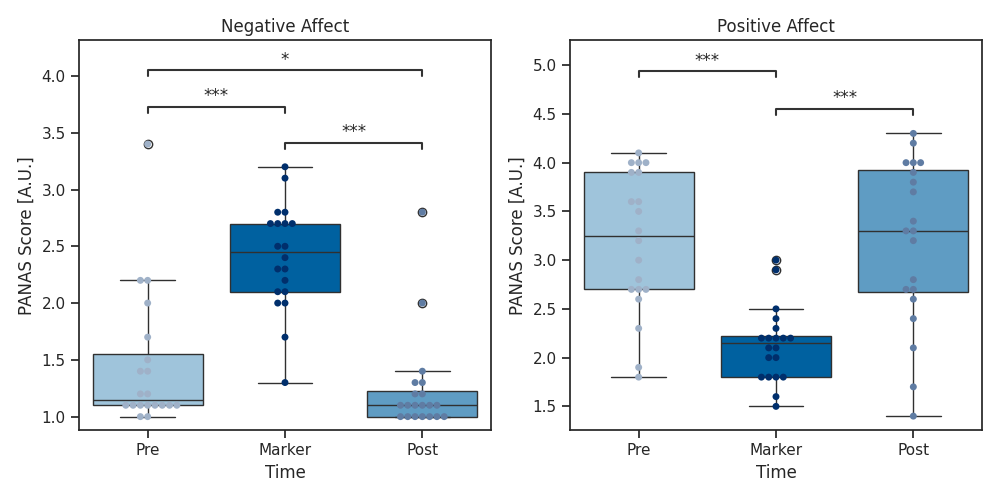

In [21]:
fig, axs = plt.subplots(ncols=2)

for (key, val), ax in zip(panas_data_omc.groupby("subscale"), axs, strict=False):
    bp.plotting.feature_boxplot(
        data=val.reset_index(),
        x="time",
        y="PANAS",
        hue="time",
        order=order,
        ax=ax,
        stats_kwargs={"pairs": box_pairs[key], "pvalues": pvalues[key], "verbose": 0},
        palette=med_dark[:3],
    )
    ax.set_title(key)
    ax.set_ylabel("PANAS Score [A.U.]")
    ax.set_xlabel("Time")
    sns.swarmplot(data=val.reset_index(), x="time", y="PANAS", ax=ax, hue="time", palette=cmaps.fau[:3])
    [l.remove() for l in fig.legends]
    
fig.tight_layout()
plt.savefig("../../exports/plots/PANAS.pdf")

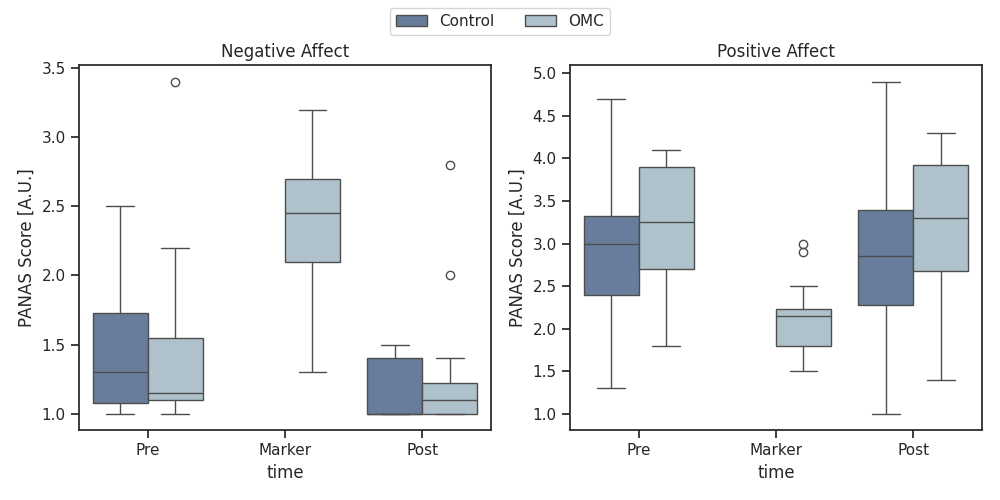

In [16]:
fig, axs = plt.subplots(ncols=2)

handles, labels = None, None
for (key, val), ax in zip(panas_data_analysis.groupby("subscale"), axs, strict=False):
    sns.boxplot(
        data=val.reset_index(), x="time", y="PANAS", hue="condition", order=order, hue_order=["Control", "OMC"], ax=ax
    )
    ax.set_title(key)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend().remove()
    ax.set_ylabel("PANAS Score [A.U.]")
    
fig.legend(handles, labels, ncols=2, loc="upper center")
fig.tight_layout(rect=(0, 0, 1, 0.95))

## SSSQ

In [22]:
sssq_data_analysis = sssq_data.reindex(["Distress", "SelfEvaluation", "Total"], level="subscale")
sssq_data_analysis = sssq_data_analysis.rename(index={"SelfEvaluation": "Self Evaluation"}, level="subscale")

sssq_data_groups = sssq_data_analysis.drop("Marker", level="time")

In [23]:
Spipeline = StatsPipeline(
    steps=[("prep", "normality"), ("test", "mixed_anova"), ("posthoc", "pairwise_tests")],
    params={
        "dv": "SSSQ",
        "subject": "participant",
        "within": "time",
        "between": "condition",
        "groupby": "subscale",
        "multicomp": {"method": "bonf", "levels": True},
    },
)

pipeline.apply(sssq_data_groups)

pipeline.display_results(sig_only=False)

<font size="3"><b> Overview </b></font>

,dv,subject,within,between,groupby,multicomp
parameter,SSSQ,participant,time,condition,subscale,"{'method': 'bonf', 'levels': True}"


,prep,test,posthoc
parameter,normality,mixed_anova,pairwise_tests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

W    pval  normal
subscale        time condition                          
Distress        Post OMC        0.549663  0.0000   False
                     Control    0.798413  0.0008   False
                Pre  OMC        0.759758  0.0002   False
                     Control    0.764196  0.0003   False
Self Evaluation Post OMC        0.946597  0.3184    True
                     Control    0.942165  0.2634    True
                Pre  OMC        0.956565  0.4777    True
                     Control    0.961446  0.5731    True
Total           Post OMC        0.797471  0.0008   False
                     Control    0.968079  0.7139    True
                Pre  OMC        0.897518  0.0371   False
                     Control    0.960897  0.5619    True

<font size="3"><b> Statistical Tests </b></font>

**Mixed ANOVA**

Source        SS  DF1  DF2        MS          F  \
subscale                                                                  
Distress        0    condition  0.162000    1   38  0.162000   0.267885   
                1         time  0.882000    1   38  0.882000   6.730120   
                2  Interaction  0.018000    1   38  0.018000   0.137349   
Self Evaluation 0    condition  0.355556    1   38  0.355556   0.274616   
                1         time  4.355556    1   38  4.355556  21.588406   
                2  Interaction  0.088889    1   38  0.088889   0.440580   
Total           0    condition  0.026584    1   38  0.026584   0.082033   
                1         time  0.605230    1   38  0.605230  16.448580   
                2  Interaction  0.002626    1   38  0.002626   0.071364   

                    p-unc       np2  eps  
subscale                                  
Distress        0  0.6078  0.007000  NaN  
                1  0.0134  0.150461  1.0  
                2  0.7130  0.003601  NaN  
Self Evaluation 0  0.6033  0.007175  NaN  
                1  0.0000  0.362292  1.0  
                2  0.5109  0.011461  NaN  
Total           0  0.7761  0.002154  NaN  
                1  0.0002  0.302094  1.0  
                2  0.7908  0.001874  NaN

<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

Contrast  time        A    B Paired Parametric  \
subscale                                                                    
Distress        0              time     -     Post  Pre   True       True   
                1         condition     -  Control  OMC  False       True   
                2  time * condition  Post  Control  OMC  False       True   
                3  time * condition   Pre  Control  OMC  False       True   
Self Evaluation 0              time     -     Post  Pre   True       True   
                1         condition     -  Control  OMC  False       True   
                2  time * condition  Post  Control  OMC  False       True   
                3  time * condition   Pre  Control  OMC  False       True   
Total           0              time     -     Post  Pre   True       True   
                1         condition     -  Control  OMC  False       True   
                2  time * condition  Post  Control  OMC  False       True   
                3  time * condition   Pre  Control  OMC  False       True   

                          T   dof alternative   p-unc     BF10    hedges  \
subscale                                                                   
Distress        0 -2.623424  39.0   two-sided  0.0124    3.404 -0.346254   
                1 -0.517576  38.0   two-sided  0.6078    0.344 -0.160420   
                2 -0.363382  38.0   two-sided  0.7183    0.326 -0.112628   
                3 -0.557592  38.0   two-sided  0.5804     0.35 -0.172823   
Self Evaluation 0 -4.680019  39.0   two-sided  0.0000  648.366 -0.539169   
                1 -0.524038  38.0   two-sided  0.6033    0.345 -0.162423   
                2 -0.784465  38.0   two-sided  0.4376    0.394 -0.243141   
                3 -0.229138  38.0   two-sided  0.8200    0.315 -0.071020   
Total           0 -4.104850  39.0   two-sided  0.0002  129.663 -0.410448   
                1  0.286414  38.0   two-sided  0.7761    0.319  0.088773   
                2  0.351369  38.0   two-sided  0.7273    0.324  0.108905   
                3  0.189041  38.0   two-sided  0.8511    0.313  0.058592   

                   p-corr  
subscale                   
Distress        0  0.1483  
                1  1.0000  
                2  1.0000  
                3  1.0000  
Self Evaluation 0  0.0004  
                1  1.0000  
                2  1.0000  
                3  1.0000  
Total           0  0.0024  
                1  1.0000  
                2  1.0000  
                3  1.0000

In [24]:
sssq_data_omc = sssq_data_analysis.xs("OMC", level="condition")

In [25]:
pipeline = StatsPipeline(
    steps=[("prep", "normality"), ("test", "rm_anova"), ("posthoc", "pairwise_tests")],
    params={
        "dv": "SSSQ",
        "subject": "participant",
        "within": "time",
        "groupby": "subscale",
        "multicomp": {"method": "bonf", "levels": True},
    },
)

pipeline.apply(sssq_data_omc)

box_pairs, pvalues = pipeline.sig_brackets(
    "posthoc", plot_type="single", x="subscale", subplots=True, stats_effect_type="within"
)

pipeline.display_results()

<font size="3"><b> Overview </b></font>

,dv,subject,within,groupby,multicomp
parameter,SSSQ,participant,time,subscale,"{'method': 'bonf', 'levels': True}"


,prep,test,posthoc
parameter,normality,rm_anova,pairwise_tests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

W    pval  normal
subscale        time                            
Distress        Marker  0.587644  0.0000   False
                Post    0.549663  0.0000   False
                Pre     0.759758  0.0002   False
Self Evaluation Marker  0.933432  0.1797    True
                Post    0.946597  0.3184    True
                Pre     0.956565  0.4777    True
Total           Marker  0.839453  0.0036   False
                Post    0.797471  0.0008   False
                Pre     0.897518  0.0371   False

<font size="3"><b> Statistical Tests </b></font>

**Repeated-measurement ANOVA**

,,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
subscale,,,,,,,,,,,,
Distress,0,time,2,38,3.016645,0.0608,0.090869,0.022515,0.588472,False,0.300683,0.000020
Self Evaluation,0,time,2,38,6.103627,0.0050,NaN,0.045801,0.902175,NaN,NaN,NaN
Total,0,time,2,38,5.744362,0.0066,0.017763,0.024122,0.647992,False,0.456770,0.000866


<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

Contrast       A     B  Paired  Parametric         T   dof  \
subscale                                                                       
Distress        0     time  Marker  Post    True        True  0.940064  19.0   
                1     time  Marker   Pre    True        True -1.581139  19.0   
                2     time    Post   Pre    True        True -1.954796  19.0   
Self Evaluation 0     time  Marker  Post    True        True  0.534522  19.0   
                1     time  Marker   Pre    True        True -3.248931  19.0   
                2     time    Post   Pre    True        True -2.897005  19.0   
Total           0     time  Marker  Post    True        True  2.420705  19.0   
                1     time  Marker   Pre    True        True -1.822238  19.0   
                2     time    Post   Pre    True        True -2.836989  19.0   

                  alternative   p-unc    BF10    hedges  p-corr  
subscale                                                         
Distress        0   two-sided  0.3590   0.344  0.056219  1.0000  
                1   two-sided  0.1304   0.674 -0.268173  1.0000  
                2   two-sided  0.0655   1.127 -0.335865  0.5893  
Self Evaluation 0   two-sided  0.5992   0.264  0.087322  1.0000  
                1   two-sided  0.0042  10.584 -0.386875  0.0380  
                2   two-sided  0.0092   5.472 -0.455375  0.0832  
Total           0   two-sided  0.0257   2.362  0.132516  0.2311  
                1   two-sided  0.0842   0.931 -0.232090  0.7578  
                2   two-sided  0.0105   4.904 -0.365652  0.0948

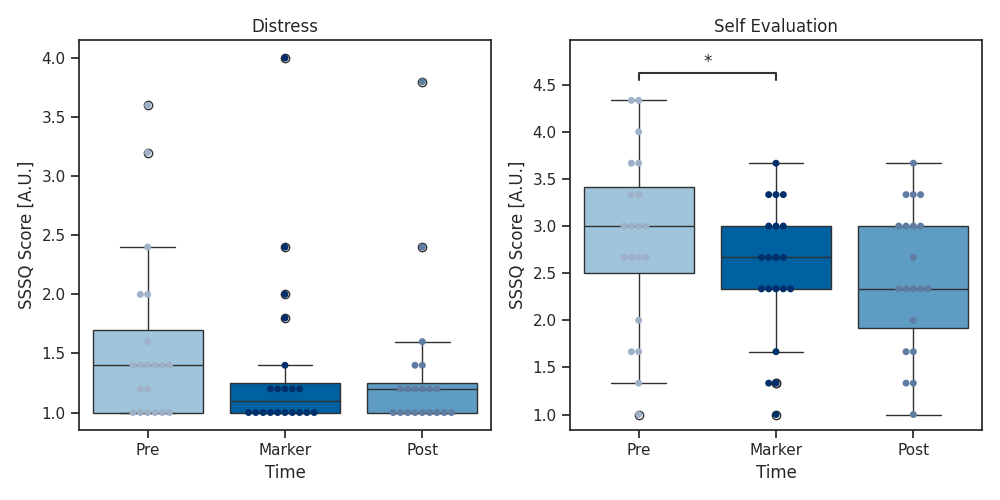

In [31]:
fig, axs = plt.subplots(ncols=2)

for (key, val), ax in zip(sssq_data_omc.groupby("subscale"), axs, strict=False):
    bp.plotting.feature_boxplot(S
        data=val.reset_index(),
        x="time",
        y="SSSQ",
        hue="time",
        order=order,
        ax=ax,
        stats_kwargs={"pairs": box_pairs.get(key, []), "pvalues": pvalues.get(key, []), "verbose": 0},
        palette=cmaps.med_dark[:3],
    )
    sns.swarmplot(data=val.reset_index(), x="time", y="SSSQ", ax=ax, hue="time", palette=cmaps.fau[:3])
    [l.remove() for l in fig.legends]
    ax.set_title(key)
    ax.set_xlabel("Time")
    ax.set_ylabel("SSSQ Score [A.U.]")

fig.tight_layout()
fig.savefig("../../exports/plots/SSSQ.pdf")

## VAS

In [ ]:
vas_data = data.filter(like="VAS")
vas_data = wide_to_long(vas_data, quest_name="VAS", levels="item")
vas_data.head()

In [ ]:
pipeline = StatsPipeline(
    steps=[("prep", "normality"), ("test", "pairwise_tests")],
    params={
        "dv": "VAS",
        "between": "condition",
        "groupby": "item",
        "multicomp": {"method": "bonf", "levels": True},
        "parametric": False,
    },
)

pipeline.apply(vas_data)

# box_pairs, pvalues = pipeline.sig_brackets("posthoc", plot_type="single", x="subscale", subplots=True, stats_effect_type="within")

pipeline.display_results(sig_only=False)

In [ ]:
fig, ax = plt.subplots()

sns.boxplot(data=vas_data.reset_index(), x="item", y="VAS", hue="condition", hue_order=hue_order, ax=ax)

fig.tight_layout()